# Projecting and Transforming Geometries

This notebook contains simple code in wich coordinate reference systems (CRS) and, projections and transformations are analyzed.

Look at the companion guide: [`README.md`](../README.md).

Table of contents:



## 3. Projecting and Transforming Geometries

The most common way to express the location on a spot in the world are the **geographic coordinates**, which are expressed in:

- Longitude: `[-180, 180] deg`; related to `x`, starting at the Equator.
- Latitude: `[-90, 90] deg`; related to `y`, starting at the Greewich meridian.

The **geographic coordinates** are a **Coordinate Reference System** or **CRS**, because they set a frame in which we can define points. In practice, there are many CRS, depending on our application, and we apply **projections** to go from one to the other.

For instance, the geographic coordinates are not the best CRS to measure distances between points, thus we need to project the CRS to get `(x, y)` values. One possible projection or CRS is Mercator.

In [2]:
import pandas as pd
import geopandas as gpd
import contextily
import matplotlib.pyplot as plt

In [3]:
DATA_PATH_PARIS = '../../data/work_geodata/Paris/'

### 3.1 Coordinate Reference Systems

We can get the CRS in which a geodataframe is expressed with `.crs`; some popular CRS are:

- `EPSG:4326` or `WGS84`: geographic coordinates, i.e., longitude & latitude.
- `EPSG:3857`: a very common projection, which has units in meters and is used in Google maps and most other apps.

To manipulate different geo-datasets, we need to make sure they're all in the same CRS. Additionally, note that:

- **All CRS projections introduce deformations. Each country/region has a best projection CRS for accurate distance computations**. See:
  - [https://spatialreference.org](https://spatialreference.org)
  - [https://epsg.io](https://epsg.io)
- Any distancce operation in geopandas/shapely expects points described on a cartesian plane. However, CRS manipulation is done only in geopandas, i.e., shapely objects work simply with cartesian floating point values.

#### Example 1: Transform GeoDataFrame CRS

In [4]:
districts = gpd.read_file(DATA_PATH_PARIS+'paris_districts_utm.geojson')

In [7]:
print(districts.crs)

epsg:32631


In [6]:
districts.head()

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((451922.133 5411438.484, 451922.080 5..."
1,2,Halles,8984,"POLYGON ((452278.419 5412160.893, 452192.407 5..."
2,3,Palais-Royal,3195,"POLYGON ((451553.806 5412340.522, 451528.058 5..."
3,4,Place-Vendôme,3044,"POLYGON ((451004.908 5412654.095, 450960.640 5..."
4,5,Gaillon,1345,"POLYGON ((451328.752 5412991.278, 451294.721 5..."


In [10]:
# We can convert a geodataframe to another CRS as follows
districts = districts.to_crs(epsg = 3857)

#### Example 2: Create a Point and Transform Its CRS

In [44]:
# Construct a Point object for the Eiffel Tower
from shapely.geometry import Point
eiffel_tower = Point(2.2945, 48.8584) # Logitude, Latitude

# Put the point in a GeoSeries with the correct CRS
s_eiffel_tower = gpd.GeoSeries([eiffel_tower], crs={'init': 'EPSG:4326'})

# Convert to other CRS
s_eiffel_tower_projected = s_eiffel_tower.to_crs(epsg=2154)

# Print the projected point
print(s_eiffel_tower_projected)

0    POINT (648237.302 6862271.682)
dtype: geometry


/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


#### Example 3: Measure Distances between Points and Plot

In [50]:
restaurants = pd.read_csv(DATA_PATH_PARIS+"paris_restaurants.csv")
restaurants = gpd.GeoDataFrame(restaurants,
                               geometry=gpd.points_from_xy(restaurants.x,
                                                           restaurants.y))

In [51]:
restaurants.geometry

0       POINT (259641.692 6251867.063)
1       POINT (259572.340 6252029.683)
2       POINT (259657.276 6252143.401)
3       POINT (259684.438 6252203.137)
4       POINT (259597.943 6252230.044)
                     ...              
5730    POINT (259415.268 6253553.831)
5731    POINT (259039.342 6253966.817)
5732    POINT (267737.068 6251037.256)
5733    POINT (267811.874 6250976.682)
5734    POINT (268032.955 6249938.191)
Name: geometry, Length: 5735, dtype: geometry

In [52]:
print(restaurants.crs)

None


In [53]:
# Restaurants are in the Web Mercator CRS
# Set it manually
restaurants.crs = {'init': 'epsg:3857'}

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [57]:
# Extract the single Point
eiffel_tower = s_eiffel_tower_projected[0]

# Ensure the restaurants use the same CRS
restaurants = restaurants.to_crs(crs=s_eiffel_tower_projected.crs) 

print(f"New CRS: {restaurants.crs}")

# The distance from each restaurant to the Eiffel Tower
dist_eiffel = restaurants.geometry.distance(eiffel_tower)

# The distance to the closest restaurant
print(dist_eiffel.min())

New CRS: epsg:2154
303.5625538786418


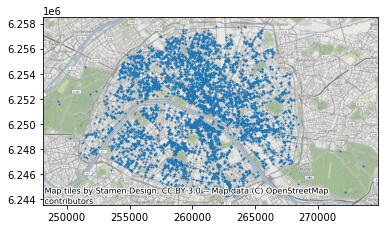

In [58]:
# Contextily requires the Web Mercator CRS
# Convert to the Web Mercator projection
restaurants_webmercator = restaurants.to_crs(epsg=3857)

# Plot the restaurants with a background map
ax = restaurants_webmercator.plot(markersize=1)
contextily.add_basemap(ax)
plt.show()

### 3.2 Spatial Operations: Creating New Geometries

We can perform spatial operations with the polygons in such a way that we get new polygons; such oprations are:

- `a.intersection.(b)`
- `a.union.(b)`
- `a.difference.(b)`

If we apply those operations between two `gpd` tables, we get a `GeoSeeries` with the same number of rows (but one column: `geometry`). Depending on the operation, these geometries can be: the same as before, different (result of the operation, e.g., intersection), or null/empty.

    gdf.intersection(box)

The next examples use a simplified version of Donstia-San Sebastian land use dataset based on the open [European Urban Atlas](https://land.copernicus.eu/local/urban-atlas).  Go to the web, log in, select map/atlas and city, and download it!


#### Example 1: Plot Dataset

In [59]:
DATA_PATH = "../../data/Donostia_Urban_Atlas/Data/"

In [63]:
# Import the land use dataset
land_use = gpd.read_file(DATA_PATH+'ES510L1_DONOSTIA_SAN_SEBASTIAN_UA2018_v013.gpkg')

In [69]:
land_use.head()

,country,fua_name,fua_code,code_2018,class_2018,prod_date,identifier,perimeter,area,comment,Pop2018,geometry
0,ES,Donostia-San Sebastián,ES510L1,11100,Continuous urban fabric (S.L. : > 80%),2020-03,176-ES510L1,244.247867,2815.288645,NaN,121,"MULTIPOLYGON (((3352920.387 2322440.803, 33528..."
1,ES,Donostia-San Sebastián,ES510L1,11300,Isolated structures,2020-03,2174-ES510L1,216.559756,2906.066983,NaN,0,"MULTIPOLYGON (((3359880.297 2316412.269, 33598..."
2,ES,Donostia-San Sebastián,ES510L1,11300,Isolated structures,2020-03,2496-ES510L1,245.246742,3597.133588,NaN,0,"MULTIPOLYGON (((3359550.890 2317186.177, 33595..."
3,ES,Donostia-San Sebastián,ES510L1,11300,Isolated structures,2020-03,2403-ES510L1,241.945303,3671.962466,NaN,10,"MULTIPOLYGON (((3352029.553 2318515.484, 33520..."
4,ES,Donostia-San Sebastián,ES510L1,12100,"Industrial, commercial, public, military and p...",2020-03,3206-ES510L1,322.561924,5087.592913,NaN,0,"MULTIPOLYGON (((3358443.760 2317973.059, 33584..."


In [70]:
land_use.shape

(5976, 12)

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


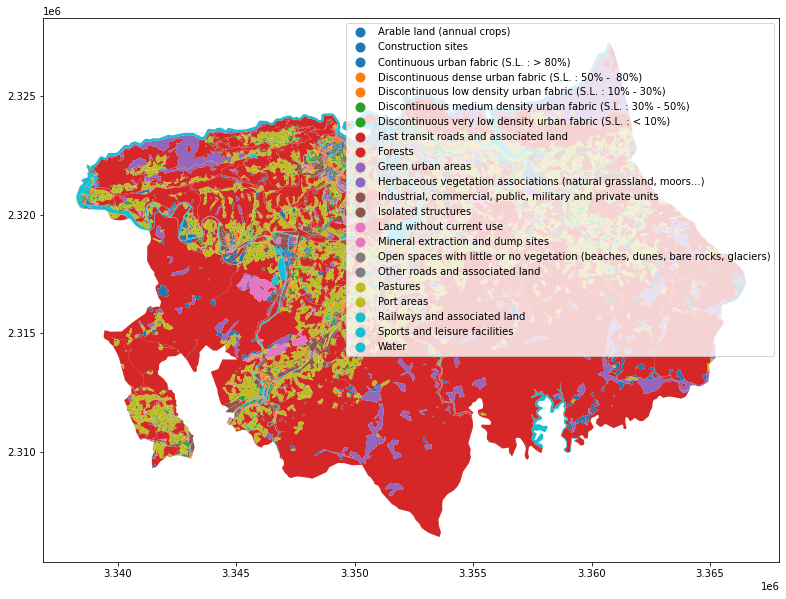

In [65]:
# Make a plot of the land use with 'class' as the color
land_use.plot(column='class_2018', legend=True, figsize=(15, 10))
plt.show()

In [66]:
# Add the area as a new column
land_use['area'] = land_use.geometry.area

In [68]:
# Calculate the total area for each land use class
total_area = land_use.groupby('class_2018')['area'].sum() / 1000**2
print(total_area.sort_values(ascending=False))

class_2018
Forests                                                                            195.821197
Pastures                                                                            48.119896
Herbaceous vegetation associations (natural grassland, moors...)                    20.452536
Industrial, commercial, public, military and private units                          15.029235
Other roads and associated land                                                      7.319181
Water                                                                                7.151335
Arable land (annual crops)                                                           5.302602
Isolated structures                                                                  4.727019
Discontinuous very low density urban fabric (S.L. : < 10%)                           4.672770
Discontinuous dense urban fabric (S.L. : 50% -  80%)                                 3.636626
Discontinuous medium density urban fabric (S.L. :

#### Example 2: Intersection

In [108]:
from shapely import Polygon
from shapely.geometry import box

# I have taken the coordinates which enclose the city center
# For more information on how to create Shapely objects
# https://shapely.readthedocs.io/en/stable/manual.html
center_polygon = box(minx=3347000, miny=2322000, maxx=3357000, maxy=2325000, ccw=True)

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

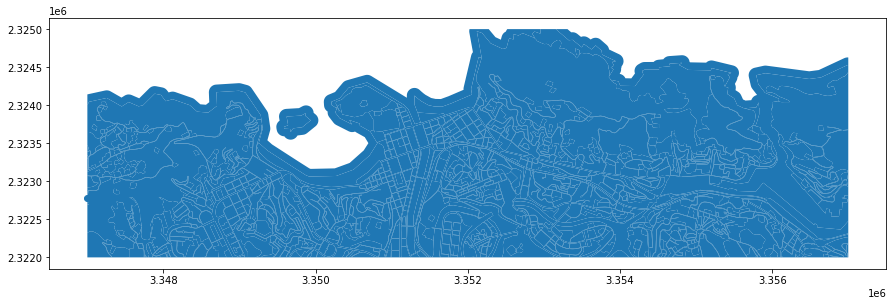

In [109]:
# Note that we pass a Shapely object to the geodataframe
land_use_intersection = land_use.intersection(center_polygon)
land_use_intersection.plot(figsize=(15,10))

In [113]:
# Note that the intersected object is a GeoSeries
# which has the same number of rows as the original gdf
# BUT one column (geometry), and additionally,
# some rows have NaN/Null value, i.e., those which do not overlap!
# The new geometries can be: same as before, intersected, or empty.
# In order to get their attributes we need to perform a join/concat.
type(land_use_intersection)

geopandas.geoseries.GeoSeries

In [114]:
land_use_intersection.shape

(5976,)

In [115]:
land_use.shape

(5976, 12)

### 3.3 Overlaying Spatial Datasets